In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# 주식데이터 불러오기

### 종목코드와 링크 생성

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [3]:
#상장된 기업들목록에서 회사명과 종목코드만 가져옴
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2353 non-null   object
 1   code    2353 non-null   object
dtypes: object(2)
memory usage: 36.9+ KB


In [4]:
#회사명을 넣으면, code_df를 뒤져서 종목코드를 찾고, 네이버주식url에 덧대서 출력해주는 함수
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    code = code[1:7]
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url

item_name = '카카오'
url = get_url(item_name, code_df)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=035720


### 날짜별 종가, 전일비, 시가, 고가, 저가, 거래량 불러오기

In [5]:
def convert_col_name_kor_eng(df):  
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['date'], ascending=True) 
    df.head()
    return df

def get_dataset(num_date):
    df = pd.DataFrame()
    for page in range(1,num_date+1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df = df.dropna()
    df = convert_col_name_kor_eng(df)
    return df

df = get_dataset(300)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 4498 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3000 non-null   datetime64[ns]
 1   close   3000 non-null   int32         
 2   diff    3000 non-null   int32         
 3   open    3000 non-null   int32         
 4   high    3000 non-null   int32         
 5   low     3000 non-null   int32         
 6   volume  3000 non-null   int32         
dtypes: datetime64[ns](1), int32(6)
memory usage: 117.2 KB


### 데이터프레임 -> 넘파이

In [7]:
df = df.drop(['date'], axis=1)
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 4498 to 1
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   3000 non-null   int32
 1   diff    3000 non-null   int32
 2   open    3000 non-null   int32
 3   high    3000 non-null   int32
 4   low     3000 non-null   int32
 5   volume  3000 non-null   int32
dtypes: int32(6)
memory usage: 93.8 KB


In [8]:
print(df_size)

3000


In [9]:
train_set = df[0:int(df_size*0.7)]

In [10]:
test_set = df[int(df_size*0.7):]

In [11]:
train = train_set.to_numpy()
test = test_set.to_numpy()
test_ba = test_set.to_numpy()

In [12]:
print(train.shape)
print(test.shape)
print(train[1])
print(train[2])

(2100, 6)
(900, 6)
[ 61700    200  62000  62200  61100 133024]
[ 64600   2900  61700  64900  60100 337513]


# 데이터 전처리

#### minmax정규화, RNN용 shape으로 변경

In [13]:
def minmax_scaler(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

def build_dataset(time_series, seq_length):
    train_size = int(len(time_series - seq_length))
    dataX = []
    dataY = []

    #print(len(time_series) - seq_length)
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i + seq_length,1:]
        _y = time_series[i + seq_length,[0]]
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)
#2차원 배열 -> 넘파이배열로 변경시 자료의 사이즈가 맞지 않으면 object타입으로 처리해서 3차원배열로 인식하지 않는다.

In [14]:
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
lr = 0.0001
epoch = 500

In [15]:
train = minmax_scaler(train)
test_min = np.min(test, 0)
test_max = np.max(test, 0)
test_denom = test_max - test_min

test = (test-test_min) / (test_denom + 1e-7)#minmax_scaler(test) 
print(train_set.shape)
print(test_set.shape)
#print(test_set.dtype)

(2100, 6)
(900, 6)


In [16]:
trainX, trainY = build_dataset(train, seq_length)
testX, testY = build_dataset(test, seq_length)

In [17]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(2093, 7, 5) (2093, 1)
(893, 7, 5) (893, 1)


### 넘파이 -> 텐서

In [18]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [19]:
def load(batch_size=64):
    
    transform = None
    train_set = data_loader(trainX, trainY, transform)
    test_set = data_loader(testX, testY, transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [20]:
train_loader, test_loader = load(batch_size=256)

In [21]:
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)#.reshape(-1,1))
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)#.reshape(-1,1))
print(trainX_tensor.shape, trainY_tensor.shape)
print(testX_tensor.shape, testY_tensor.shape)

torch.Size([2093, 7, 5]) torch.Size([2093, 1])
torch.Size([893, 7, 5]) torch.Size([893, 1])


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 학습 모델

In [41]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)
              
    def forward(self, x):
        x, _status  = self.rnn(x)
        x = self.fc(x[:,-1])
        return x
              
model = Net(data_dim, hidden_dim, output_dim, 4).to(device)

In [42]:
loss_func = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [43]:
loss_arr = []
for i in range(epoch):
    for j, [x, y] in enumerate(train_loader):
        
        train_x = x.to(device).float()
        train_y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model.forward(train_x)
        
        #print(outputs.shape, train_y.shape)
        #print(outputs.dtype, train_y.dtype)
        
        loss = loss_func(outputs, train_y)
        #이걸 변수명을 같게하면 안되지!
        loss.backward()
        optimizer.step()
        loss_arr.append(loss)
    print(i, loss)

0 tensor(0.4935, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.4820, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.4433, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.4848, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.4669, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.4390, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.4513, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.4687, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.4580, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.4627, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.4761, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.4427, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.4141, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.4322, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.4174, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.3998, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.4262, 

132 tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward>)
133 tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward>)
134 tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward>)
135 tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward>)
136 tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward>)
137 tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward>)
138 tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward>)
139 tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
140 tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward>)
141 tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward>)
142 tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward>)
143 tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward>)
144 tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward>)
145 tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward>)
146 tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
147 tensor(0.0314, device='cuda:0', grad_fn=<MseLossBac

263 tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
264 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)
265 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)
266 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)
267 tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward>)
268 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)
269 tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward>)
270 tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)
271 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)
272 tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)
273 tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward>)
274 tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)
275 tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)
276 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
277 tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward>)
278 tensor(0.0023, device='cuda:0', grad_fn=<MseLossBac

394 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)
395 tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward>)
396 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)
397 tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)
398 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)
399 tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)
400 tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward>)
401 tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward>)
402 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)
403 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
404 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)
405 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
406 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)
407 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
408 tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward>)
409 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBac

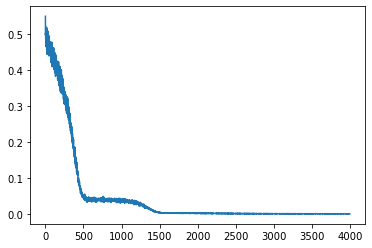

In [44]:
plt.plot(loss_arr)

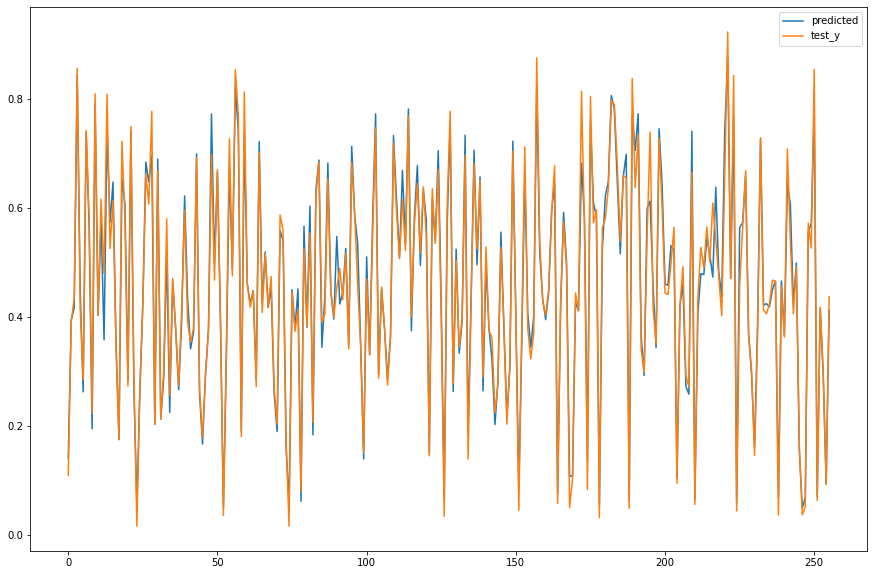

In [49]:
plt.figure(figsize=(15,10))
plt.plot(outputs.cpu().detach().numpy())
plt.plot(train_y.cpu().detach().numpy())
plt.legend(['predicted', 'test_y'])
plt.show()

## 모델 테스트

In [46]:
correct = 0
total = 0
loss_arr = []

model.eval()
with torch.no_grad():
    for j, [x, y] in enumerate(test_loader):
        test_x = x.to(device).float()
        test_y = y.to(device).float()
        test_x = testX_tensor.to(device).float()
        test_y = testY_tensor.to(device).float()
        predicted = model.forward(test_x)
        loss = loss_func(predicted, test_y)
        
        total += y.size(0)
        print(y.shape, predicted.shape)
        #print(y, predicted)
        loss_arr.append(loss)
        print(i, loss)
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    #print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))

torch.Size([256, 1]) torch.Size([893, 1])
499 tensor(0.0085, device='cuda:0')
torch.Size([256, 1]) torch.Size([893, 1])
499 tensor(0.0085, device='cuda:0')
torch.Size([256, 1]) torch.Size([893, 1])
499 tensor(0.0085, device='cuda:0')
torch.Size([125, 1]) torch.Size([893, 1])
499 tensor(0.0085, device='cuda:0')


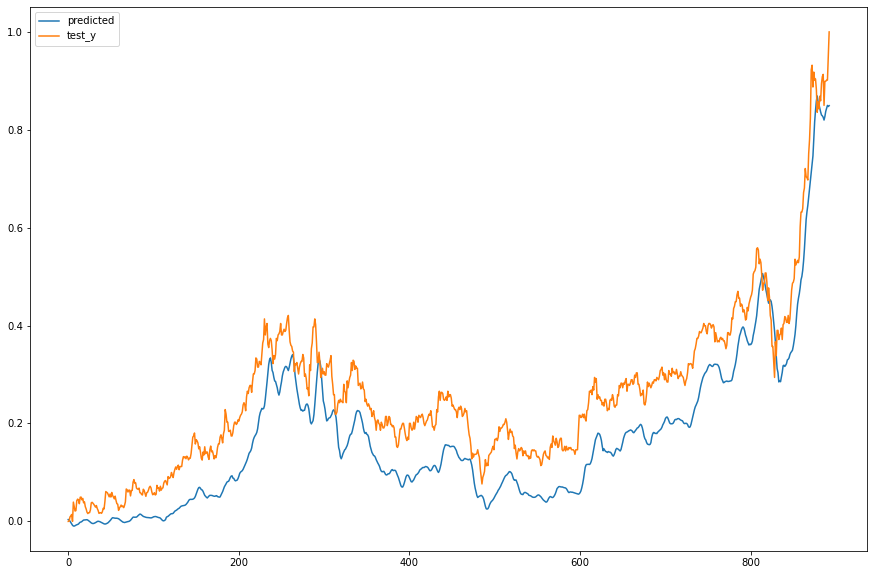

In [47]:
plt.figure(figsize=(15,10))
plt.plot(predicted.cpu())
plt.plot(test_y.cpu())
plt.legend(['predicted', 'test_y'])
plt.show()

In [48]:
print(predicted[-1], test_y[-1])

tensor([0.8493], device='cuda:0') tensor([1.], device='cuda:0')


In [31]:
def minmax_scaler(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [32]:
def reverse_minmax_sacler(val):
    predict_result = np.array((val.cpu() * (np.max(test,0)-np.min(test,0)+ 1e-7)[0]) + np.min(train,0)[0])
    return predict_result

In [33]:
train

array([[0.25419355, 0.16292135, 0.3204698 , 0.34079738, 0.32572732,
        0.08531992],
       [0.25548387, 0.01123596, 0.34675615, 0.33970508, 0.34854535,
        0.03652324],
       [0.27419355, 0.16292135, 0.3450783 , 0.35445112, 0.34284084,
        0.09266801],
       ...,
       [0.38451613, 0.0505618 , 0.45302013, 0.44893501, 0.45864233,
        0.06766151],
       [0.38      , 0.03932584, 0.45917226, 0.45275806, 0.46206503,
        0.07648399],
       [0.37741935, 0.02247191, 0.45637584, 0.44620426, 0.45864233,
        0.05278578]])

In [34]:
np.min(train,0)

array([0., 0., 0., 0., 0., 0.])

In [35]:
train-np.min(train,0)


array([[0.25419355, 0.16292135, 0.3204698 , 0.34079738, 0.32572732,
        0.08531992],
       [0.25548387, 0.01123596, 0.34675615, 0.33970508, 0.34854535,
        0.03652324],
       [0.27419355, 0.16292135, 0.3450783 , 0.35445112, 0.34284084,
        0.09266801],
       ...,
       [0.38451613, 0.0505618 , 0.45302013, 0.44893501, 0.45864233,
        0.06766151],
       [0.38      , 0.03932584, 0.45917226, 0.45275806, 0.46206503,
        0.07648399],
       [0.37741935, 0.02247191, 0.45637584, 0.44620426, 0.45864233,
        0.05278578]])

In [36]:
np.max(train,0)

array([1., 1., 1., 1., 1., 1.])

In [37]:
(np.max(test,0)-np.min(test,0))

array([1., 1., 1., 1., 1., 1.])

In [38]:
predict_result = np.array((predicted.cpu() * (np.max(test,0)-np.min(test,0)+ 1e-7)[0]) + np.min(train,0)[0])

In [39]:
predict_result.shape

(893, 1)

In [40]:
print(pred.shape)

NameError: name 'pred' is not defined

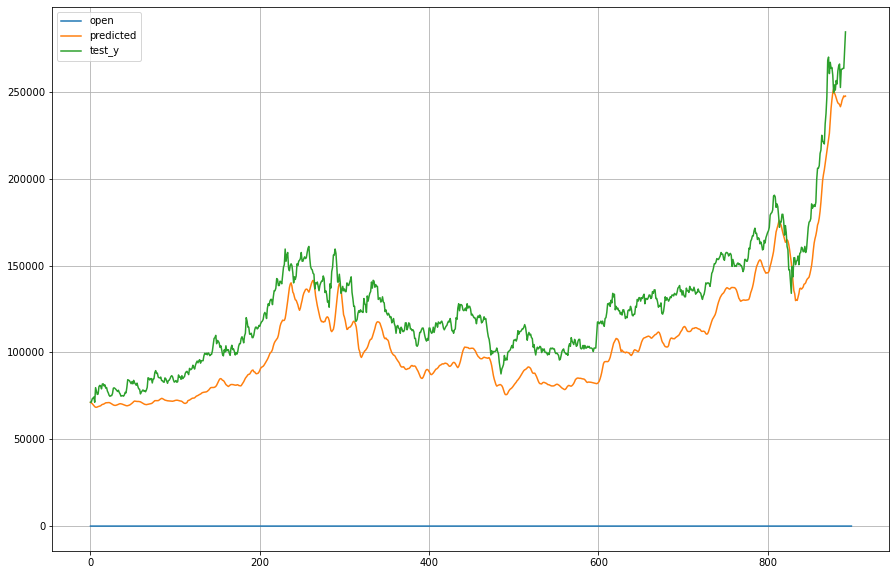

In [50]:
#pred = reverse_minmax_sacler(predicted)
#t_y = reverse_minmax_sacler(test_y)
pred = predicted.cpu() * test_denom[2] + test_min[2]
t_y = test_y.cpu() * test_denom[0] + test_min[0]
plt.figure(figsize=(15,10))
plt.plot(test[:,2])
plt.plot(pred)
plt.plot(t_y)
plt.legend(['open','predicted', 'test_y'])
plt.grid(True)
#plt.xticks([i for i in range(0,len(predicted.cpu()))])
plt.show()

In [51]:
#매일 아침에 사고, 밤에 판다는 가정하에 수익

In [52]:
print(test)
print(test.shape)

[[0.04409006 0.0047619  0.05417066 0.04205176 0.051183   0.00675119]
 [0.05159475 0.07619048 0.04745925 0.04667283 0.05021729 0.03711861]
 [0.04502814 0.06666667 0.05752637 0.04574861 0.05070014 0.01448233]
 ...
 [0.90150094 0.         0.94487057 0.90988909 0.92757122 0.1575451 ]
 [0.95075047 0.5        0.92569511 0.93992606 0.92032834 0.37071652]
 [1.         0.5        1.         1.         1.         0.34439248]]
(900, 6)


In [53]:
test = test * test_denom[0] +test_min[0]

In [54]:
test = test_ba

In [55]:
money = 0
for i in range(1,893):
    print(i, '시작가', '종가')
    print(int(pred[i-1][0]), int(pred[i][0]), int(pred[i][0]-pred[i-1][0]))
    print(int(test[i][0]), int(test[i][2]), int(test[i][2]-test[i][0]))
    if (pred[i][0]-pred[i-1][0]) > 0: #돈벌거라고 예상
        money = money + test[i][2]-test[i][0] # 실제 벌은 돈
    print(int(money))
    print('-----------------------')

1 시작가 종가
71166 70921 -244
82300 80300 -2000
0
-----------------------
2 시작가 종가
70921 70517 -404
80900 82400 1500
0
-----------------------
3 시작가 종가
70517 69917 -599
81300 80900 -400
0
-----------------------
4 시작가 종가
69917 69291 -625
79600 80900 1300
0
-----------------------
5 시작가 종가
69291 68762 -529
76400 79600 3200
0
-----------------------
6 시작가 종가
68762 68436 -325
74600 75600 1000
0
-----------------------
7 시작가 종가
68436 68394 -41
71300 74000 2700
0
-----------------------
8 시작가 종가
68394 68557 163
71400 70400 -1000
-1000
-----------------------
9 시작가 종가
68557 68791 233
73200 71200 -2000
-3000
-----------------------
10 시작가 종가
68791 68943 151
73700 73200 -500
-3500
-----------------------
11 시작가 종가
68943 69067 123
74300 74300 0
-3500
-----------------------
12 시작가 종가
69067 69260 193
71300 74300 3000
-500
-----------------------
13 시작가 종가
69260 69722 462
79700 75300 -4400
-4900
-----------------------
14 시작가 종가
69722 70052 329
77800 79800 2000
-2900
-----------------------
15 시작가 종가

80816 81215 399
101500 97800 -3700
-32900
-----------------------
166 시작가 종가
81215 81502 287
100200 101700 1500
-31400
-----------------------
167 시작가 종가
81502 81511 9
103800 100700 -3100
-34500
-----------------------
168 시작가 종가
81511 81478 -33
100800 102200 1400
-34500
-----------------------
169 시작가 종가
81478 81392 -85
101500 102400 900
-34500
-----------------------
170 시작가 종가
81392 81225 -167
101500 100300 -1200
-34500
-----------------------
171 시작가 종가
81225 81131 -94
99400 102400 3000
-34500
-----------------------
172 시작가 종가
81131 81095 -36
98300 99900 1600
-34500
-----------------------
173 시작가 종가
81095 81294 199
102500 98500 -4000
-38500
-----------------------
174 시작가 종가
81294 81372 77
104100 103300 -800
-39300
-----------------------
175 시작가 종가
81372 80945 -426
101600 103500 1900
-39300
-----------------------
176 시작가 종가
80945 80864 -80
102000 102500 500
-39300
-----------------------
177 시작가 종가
80864 80717 -146
100500 102500 2000
-39300
-----------------------
178 시작가 종가
80

139000 135500 -3500
-101800
-----------------------
345 시작가 종가
113867 112282 -1585
138000 139000 1000
-101800
-----------------------
346 시작가 종가
112282 110108 -2173
138000 137000 -1000
-101800
-----------------------
347 시작가 종가
110108 108538 -1569
130500 135000 4500
-101800
-----------------------
348 시작가 종가
108538 107854 -684
131000 129500 -1500
-101800
-----------------------
349 시작가 종가
107854 108292 438
131500 134500 3000
-98800
-----------------------
350 시작가 종가
108292 107540 -752
129000 129000 0
-98800
-----------------------
351 시작가 종가
107540 107281 -259
129500 129500 0
-98800
-----------------------
352 시작가 종가
107281 106499 -781
132000 131500 -500
-98800
-----------------------
353 시작가 종가
106499 104546 -1953
129000 132500 3500
-98800
-----------------------
354 시작가 종가
104546 102435 -2111
128500 127000 -1500
-98800
-----------------------
355 시작가 종가
102435 101068 -1366
123500 129000 5500
-98800
-----------------------
356 시작가 종가
101068 99800 -1267
124500 125000 500
-98800
-------

-165500
-----------------------
542 시작가 종가
81414 81320 -94
101000 101000 0
-165500
-----------------------
543 시작가 종가
81320 81078 -241
102000 101000 -1000
-165500
-----------------------
544 시작가 종가
81078 80798 -280
100000 102000 2000
-165500
-----------------------
545 시작가 종가
80798 80667 -131
99900 100000 100
-165500
-----------------------
546 시작가 종가
80667 80653 -13
100000 100500 500
-165500
-----------------------
547 시작가 종가
80653 80692 38
98500 100000 1500
-164000
-----------------------
548 시작가 종가
80692 80856 164
99600 99000 -600
-164600
-----------------------
549 시작가 종가
80856 81170 313
98800 99900 1100
-163500
-----------------------
550 시작가 종가
81170 81501 331
102000 99400 -2600
-166100
-----------------------
551 시작가 종가
81501 81675 173
102500 101500 -1000
-167100
-----------------------
552 시작가 종가
81675 81575 -99
102000 102500 500
-167100
-----------------------
553 시작가 종가
81575 81261 -314
102500 101500 -1000
-167100
-----------------------
554 시작가 종가
81261 80932 -329
102000 103

-182300
-----------------------
683 시작가 종가
103193 103908 715
122000 118500 -3500
-185800
-----------------------
684 시작가 종가
103908 106159 2251
123500 124500 1000
-184800
-----------------------
685 시작가 종가
106159 107597 1438
127000 128000 1000
-183800
-----------------------
686 시작가 종가
107597 108262 664
132000 128000 -4000
-187800
-----------------------
687 시작가 종가
108262 108225 -37
130000 133000 3000
-187800
-----------------------
688 시작가 종가
108225 107864 -360
131500 130000 -1500
-187800
-----------------------
689 시작가 종가
107864 107918 53
130500 133000 2500
-185300
-----------------------
690 시작가 종가
107918 107827 -90
129500 129500 0
-185300
-----------------------
691 시작가 종가
107827 108404 577
130500 130500 0
-185300
-----------------------
692 시작가 종가
108404 108753 348
132000 131000 -1000
-186300
-----------------------
693 시작가 종가
108753 109113 360
131500 131000 -500
-186800
-----------------------
694 시작가 종가
109113 109463 349
133000 131500 -1500
-188300
-----------------------
695 시작가

-222800
-----------------------
793 시작가 종가
152790 151485 -1305
168500 171500 3000
-222800
-----------------------
794 시작가 종가
151485 149769 -1716
168500 169000 500
-222800
-----------------------
795 시작가 종가
149769 148752 -1016
165000 168500 3500
-222800
-----------------------
796 시작가 종가
148752 147368 -1384
166000 166000 0
-222800
-----------------------
797 시작가 종가
147368 146419 -948
165500 168000 2500
-222800
-----------------------
798 시작가 종가
146419 145566 -853
162500 160000 -2500
-222800
-----------------------
799 시작가 종가
145566 145895 329
163500 165500 2000
-220800
-----------------------
800 시작가 종가
145895 145728 -166
162000 163000 1000
-220800
-----------------------
801 시작가 종가
145728 146159 430
159000 162500 3500
-217300
-----------------------
802 시작가 종가
146159 147215 1055
159500 156000 -3500
-220800
-----------------------
803 시작가 종가
147215 149672 2457
164500 161500 -3000
-223800
-----------------------
804 시작가 종가
149672 151326 1654
163000 166500 3500
-220300
-------------------